In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [44]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [45]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [46]:
train_img.shape

(42000, 28, 28)

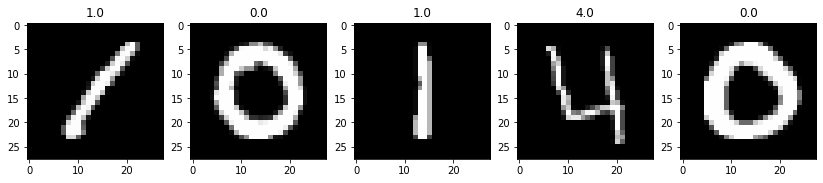

In [47]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [48]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [49]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [50]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [51]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

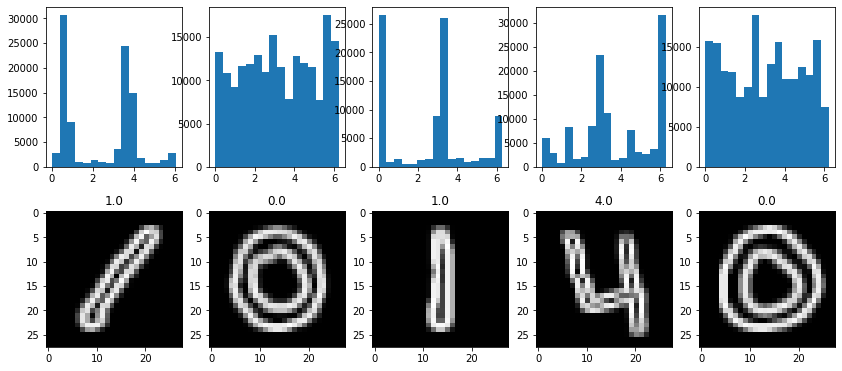

In [52]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

In [53]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [54]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

In [55]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [56]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [58]:
train_hist.shape

(42000, 16)

In [59]:
test_hist.shape

(28000, 16)

### С PCA

In [60]:
from sklearn.decomposition import PCA

In [129]:
pca = PCA(n_components=5)

In [131]:
train=pca.fit_transform(train_hist)

In [132]:
test=pca.transform(test_hist)

In [133]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train, test_size=0.2,
    random_state=42)

In [134]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=50)

In [135]:
neigh.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [136]:
pred_val=neigh.predict(x_val)

In [137]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.5178571428571429


### Без PCA

In [145]:

y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

In [146]:

neigh = KNeighborsClassifier(n_neighbors=50)

In [147]:
neigh.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [148]:
pred_val=neigh.predict(x_val)

In [149]:

print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.616904761904762


##### Точность без PCA выше...

In [138]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.32      0.34      0.33       816
         1.0       0.94      0.95      0.94       909
         2.0       0.38      0.31      0.34       846
         3.0       0.48      0.58      0.52       937
         4.0       0.59      0.61      0.60       839
         5.0       0.48      0.47      0.47       702
         6.0       0.31      0.29      0.30       785
         7.0       0.80      0.58      0.67       893
         8.0       0.43      0.51      0.47       835
         9.0       0.46      0.46      0.46       838

    accuracy                           0.52      8400
   macro avg       0.52      0.51      0.51      8400
weighted avg       0.53      0.52      0.52      8400



In [139]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[279   6  55  55  25   8 137   1 191  59]
 [  8 867   1   0  17   0   4   2   1   9]
 [ 52   0 260 180   1 151  50  23 103  26]
 [ 31   0  93 546   0 153  12   2  95   5]
 [ 46  37   3   1 510   0  78  52  26  86]
 [  7   0  85 223   0 333   3  10  28  13]
 [175   2  54  16  63   5 228  14  81 147]
 [ 10  11  48   9 159  19  38 518   8  73]
 [152   0  44 110   3  20  56   1 424  25]
 [110   3  38   9  88  12 140  25  28 385]]


In [140]:
pred_test=neigh.predict(test)

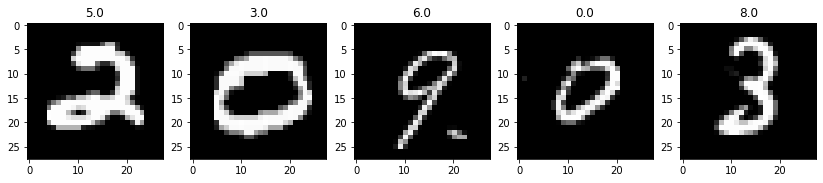

In [141]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

In [142]:
pred_test=np.array(pred_test, dtype=int) 

In [143]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))